## Load Data

In [1]:
"""Load Data
Structure:
    1. Imports, Variables, Functions
    2. Load Data
"""

# 1. Imports, Variables, Functions
# imports
import pandas as pd, numpy as np, os, sys
import anndata as ad
import logging
from typing import *
import pickle

logging.basicConfig(level=logging.INFO)

# variables
run_dir = os.path.join("..", "outputs", "run-24-09-12-02")


# functions


def load_run_output(input_dir: str) -> tuple:
    """Load the output of a run
    Args:
        input_dir (str): path to the run output directory
    Returns:
        loaded_variables (tuple): tuple of loaded variables
    """

    variables_to_load = [
        "predictions_test",
        "labels_test",
        "results_test",
        "all_outputs_test",
        "predictions_train",
        "labels_train",
        "results_train",
        "all_outputs_train",
        "adata_train",
        "adata_test",
        "id2type",
    ]

    # initialize loaded variables as an empty tuple
    loaded_variables = ()

    # loop through variables
    for variable in variables_to_load:
        if variable.startswith("adata"):
            loaded_variable = ad.read_h5ad(os.path.join(input_dir, f"{variable}.h5ad"))
        else:
            with open(os.path.join(input_dir, f"{variable}.pkl"), "rb") as f:
                loaded_variable = pickle.load(f)

        # add the loaded variable to the tuple
        loaded_variables += (loaded_variable,)

    print(f"Nº of loaded variables {len(loaded_variables)}")

    return loaded_variables


# 2. Load Data
(
    predictions_test,
    labels_test,
    results_test,
    all_outputs_test,
    predictions_train,
    labels_train,
    results_train,
    all_outputs_train,
    adata_train,
    adata_test,
    id2type,
) = load_run_output(run_dir)

Nº of loaded variables 11


In [2]:
adata_test.obs["disease"].value_counts()

disease
Breast Cancer           423
Control                 422
Colorectal Carcinoma    294
Influenza               129
Name: count, dtype: int64

In [3]:
adata_train.obs["disease"].value_counts()

disease
Control                 1812
Breast Cancer           1353
Colorectal Carcinoma    1159
Influenza                521
Name: count, dtype: int64

In [4]:
from typing import *


def merge_embeddings(output: List[Dict]) -> np.array:
    """Merge Embeddings
    Args:
        output (List[Dict]): List of dictionaries with embeddings
    Returns:
        np.array: Merged embeddings
    """
    for i in range(len(output)):
        embeddings_i = output[i]["cell_emb"].numpy()

        if i == 0:
            embeddings = embeddings_i
        else:
            embeddings = np.concatenate((embeddings, embeddings_i), axis=0)
    return embeddings


scgpt_emb_test = merge_embeddings(all_outputs_test)
logging.info(f"SCGPT Embeddings Test Shape: {scgpt_emb_test.shape}")

scgpt_emb_train = merge_embeddings(all_outputs_train)
logging.info(f"SCGPT Embeddings Train Shape: {scgpt_emb_train.shape}")

INFO:root:SCGPT Embeddings Test Shape: (1268, 512)
INFO:root:SCGPT Embeddings Train Shape: (4845, 512)


In [5]:
results_test

{'test/accuracy': 0.33280757097791797,
 'test/precision': 0.08320189274447949,
 'test/recall': 0.25,
 'test/macro_f1': 0.12485207100591716}

In [6]:
np.isnan(adata_test.X[100]).sum()

2234

In [7]:
diseases_of_interest_set = adata_test.obs["disease_study"].unique()

d_data = dict()
d_data["n_diseases"] = dict()
d_data["n_controls"] = dict()
d_data["n_datasets"] = dict()
d_data["n_genes"] = dict()
d_data["n_de_signatures"] = dict()


for disease in diseases_of_interest_set:
    # Nº Disease Samples
    states = adata_test.obs.query(f'disease_study == "{disease}"')["celltype"].to_list()
    n_diseases = len(states) - states.count("Control")
    logging.info(f"{disease} Nº of Diseases: {n_diseases}")

    # Nº of Control Samples
    n_controls = states.count("Control")
    logging.info(f"{disease} Nº Controls: {n_controls}")

    # Nº of Datasets
    datasets = adata_test.obs.query(f'disease_study == "{disease}"')[
        "dataset"
    ].to_list()
    n_datasets = len(set(datasets))
    logging.info(f"{disease} Nº of Datasets: {len(datasets)}")

    # Nº of Genes
    n_genes = adata_test.obs.query(f'disease_study == "{disease}"')["n_genes"].to_list()
    logging.info(
        f"{disease} Nº of Genes: {np.mean(n_genes):.0f} ± {np.std(n_genes):.0f}"
    )

    # Nº of DE signatures
    all_ids = adata_test.obs.query(f'disease_study == "{disease}"')["ids"].to_list()

    de_signatures = list(set([id.split(";")[0] for id in all_ids]))
    n_de_signatures = len(de_signatures)
    logging.info(f"{disease} Nº of DE Signatures: {n_de_signatures}")

    # append to dictionary
    d_data["n_diseases"][disease] = n_diseases
    d_data["n_controls"][disease] = n_controls
    d_data["n_datasets"][disease] = len(datasets)
    d_data["n_genes"][disease] = n_genes
    d_data["n_de_signatures"][disease] = n_de_signatures

INFO:root:Colorectal Carcinoma Nº of Diseases: 294
INFO:root:Colorectal Carcinoma Nº Controls: 264
INFO:root:Colorectal Carcinoma Nº of Datasets: 558
INFO:root:Colorectal Carcinoma Nº of Genes: 17758 ± 924
INFO:root:Colorectal Carcinoma Nº of DE Signatures: 19
INFO:root:Breast Cancer Nº of Diseases: 423
INFO:root:Breast Cancer Nº Controls: 29
INFO:root:Breast Cancer Nº of Datasets: 452
INFO:root:Breast Cancer Nº of Genes: 17071 ± 199
INFO:root:Breast Cancer Nº of DE Signatures: 4
INFO:root:Influenza Nº of Diseases: 129
INFO:root:Influenza Nº Controls: 129
INFO:root:Influenza Nº of Datasets: 258
INFO:root:Influenza Nº of Genes: 18284 ± 273
INFO:root:Influenza Nº of DE Signatures: 43


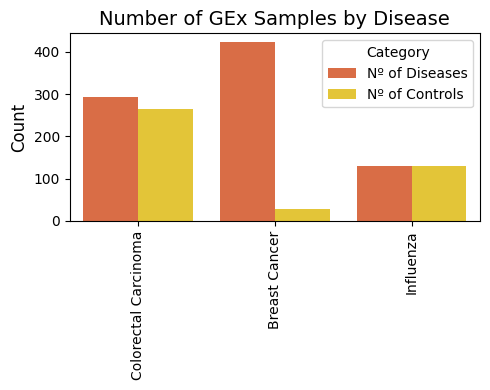

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt

irb_colors = [
    "#ffd81cff",
    "#f6972dff",
    "#f2612dff",
    "#574270ff",
    "#00589bff",
    "#002f58ff",
]

labels = list(d_data["n_diseases"].keys())
n_controls = [d_data["n_controls"][x] for x in labels]
n_diseases = [d_data["n_diseases"][x] for x in labels]

df_plot = pd.DataFrame(
    {
        "Disease": labels,
        "Nº of Diseases": n_diseases,
        "Nº of Controls": n_controls,
    }
)

# Transform the DataFrame to long format
df_long = df_plot.melt(id_vars="Disease", var_name="Category", value_name="Count")

# Plotting with seaborn
plt.figure(figsize=(5, 4))
sns.barplot(
    data=df_long,
    x="Disease",
    y="Count",
    hue="Category",
    palette=[irb_colors[2], irb_colors[0]],
)

# Adding labels and title
plt.xlabel("", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Number of GEx Samples by Disease", fontsize=14)
plt.xticks(rotation=90)

plt.tight_layout()
# plt.savefig("outputs/n_samples.png", dpi=300, bbox_inches="tight")

/tmp/ipykernel_5077/3104471250.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Text(0.5, 1.0, 'Nº of Genes across Diseases')

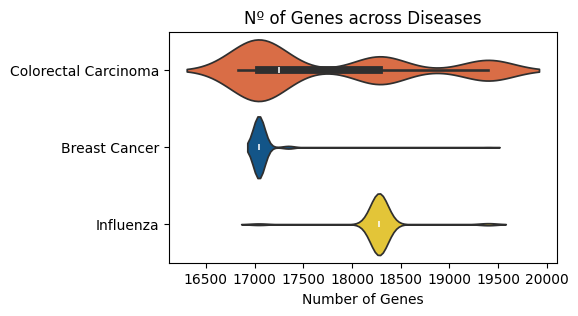

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming d_data is defined and contains the necessary data
labels = list(d_data["n_diseases"].keys())
n_genes = [d_data["n_genes"][x] for x in labels]

flat_genes = []
flat_labels = []
for label, genes_list in zip(labels, n_genes):
    flat_genes.extend(genes_list)
    flat_labels.extend([label] * len(genes_list))

plt.figure(figsize=(5, 3))

# Violin plot
sns.violinplot(
    x=flat_genes, y=flat_labels, palette=[irb_colors[2], irb_colors[4], irb_colors[0]]
)

# Adding titles and labels
plt.xlabel("Number of Genes")
plt.ylabel("")
plt.title("Nº of Genes across Diseases")
# plt.savefig("outputs/n_genes.png", dpi=300, bbox_inches="tight")

## Explore Embeddings

In [10]:
"""Explore Embeddings

Structure:
    1. Imports, Variables, Functions
    2. PCA Plots
    3. UMAP Plots
    4. Cosine Distance
    5. Pearson Correlation
    6. Euclidean Distance
"""

# 1. Imports, Variables, Functions
# imports
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array
from scipy.interpolate import make_interp_spline
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array
from scipy.interpolate import make_interp_spline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# variables

irb_colors = [
    "#ffd81cff",
    "#f6972dff",
    "#f2612dff",
    "#574270ff",
    "#00589bff",
    "#002f58ff",
]

irb_colors = ["#ffb234", "#ff958e", "#ff6028", "#2779ff", "#022778"]


# functions
def plot_metrics(values, labels, metric, output_type="", save=False):

    assert metric in [
        "Cosine Distance",
        "Euclidean Distance",
        "Pearson Correlation",
    ], "Invalid metric"

    min_val = min([x for sublist in values for x in sublist])
    max_val = max([x for sublist in values for x in sublist])

    # change min max values
    if metric == "Cosine Distance":
        min_val = 0
        max_val = 2
    elif metric == "Pearson Correlation":
        min_val = -1
        max_val = 1

    # Get a color map
    cmap = plt.get_cmap("hsv")

    # Define unique colors
    colors = [cmap(i / len(labels)) for i in range(len(labels))]

    # Define bin range
    bin_range = np.arange(min_val, max_val + 0.01, (max_val - min_val) / 20)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(4, 4))

    for i, (v, l) in enumerate(zip(values, labels)):

        # Plot control vs control
        density, bins = np.histogram(
            v, bins=bin_range, density=True
        )  # Calculate the density
        bin_centers = 0.5 * (bins[1:] + bins[:-1])  # Calculate the center of each bin
        ax.plot(
            bin_centers, density, "-", color=colors[i], label=l
        )  # Create the density plot

    # Set y-axis limit
    ax.set_ylim(0, np.max(density) * 1.1)

    # Set x-axis limit
    ax.set_xlim(min_val, max_val)

    # Add labels and title
    ax.set_xlabel(f"{metric}")
    ax.set_ylabel("Density")
    ax.set_title(f"Pairwise {metric} Distributions")

    # Add legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    # Show grid
    ax.grid(True)

    # Show plot
    if save:
        plt.savefig(
            f"outputs/pairwise_{metric.lower().replace(' ', '_')}.scgpt.{output_type}.png",
            dpi=300,
            bbox_inches="tight",
        )


def get_pairwise_similarities(matrix, indexes_1, indexes_2=None):

    pairs = list()
    if indexes_2 is not None:

        for i in indexes_1:
            for j in indexes_2:
                pairs.append([i, j])

        pairs = np.array(pairs)
        return matrix[pairs[:, 0], pairs[:, 1]]

    else:
        for n, i in enumerate(indexes_1):
            for j in indexes_1[n + 1 :]:
                pairs.append([i, j])

        pairs = np.array(pairs)
        return matrix[pairs[:, 0], pairs[:, 1]]

### 2. UMAP Plots

In [11]:
import matplotlib.pyplot as plt
import umap
from mpl_toolkits.mplot3d import Axes3D

# Perform UMAP with 3 components
umap_model = umap.UMAP(n_components=3)
umap_embedding = umap_model.fit_transform(scgpt_emb_train)

/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Text(0.5, 0.92, '3D UMAP Representation\nDisease vs Control')

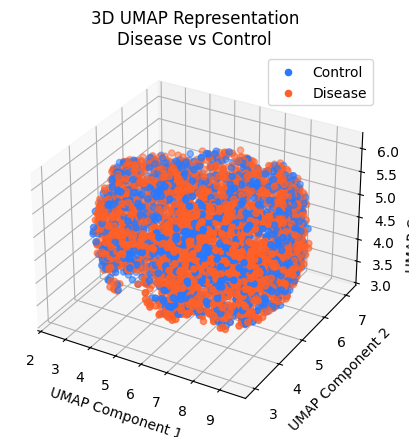

In [12]:
labels = [
    "Disease" if c != "Control" else "Control"
    for c in adata_train.obs["celltype"].to_list()
]

# Map labels to colors
label_color_map = {"Control": irb_colors[3], "Disease": irb_colors[2]}
colors = [label_color_map.get(label, "grey") for label in labels]

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Scatter plot with colors
ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], umap_embedding[:, 2], c=colors)

# Adding legend
for label in label_color_map:
    ax.scatter([], [], [], c=label_color_map[label], label=label)
ax.legend()

# Set labels
ax.set_xlabel("UMAP Component 1")
ax.set_ylabel("UMAP Component 2")
ax.set_zlabel("UMAP Component 3")
ax.set_title("3D UMAP Representation\nDisease vs Control")

# Display the plot
# plt.savefig("outputs/umap_3d.scgpt.disease_control.png", dpi=300, bbox_inches="tight")

/tmp/ipykernel_82752/2510640111.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap(
/tmp/ipykernel_82752/2510640111.py:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], [], c=label_color_map[label], label=label)


Text(0.5, 0.92, '3D UMAP Representation\nDisease Types')

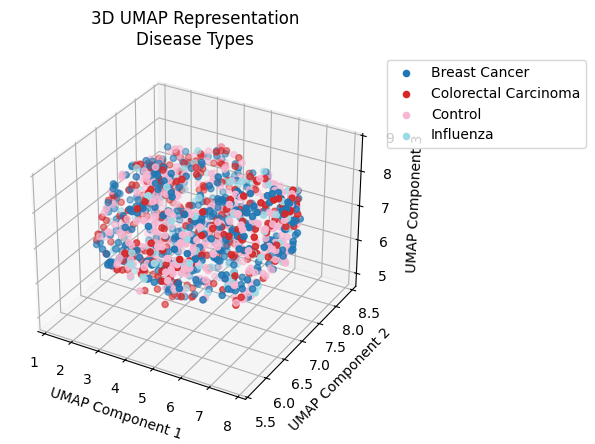

In [59]:
labels = adata_test.obs["celltype"].to_list()
unique_labels = list(set(labels))
unique_labels.sort()

# label_color_map = {
#     k: v
#     for k, v in zip(
#         unique_labels, [irb_colors[0], irb_colors[4], irb_colors[3], irb_colors[2]]
#     )
# }
# colors = [label_color_map.get(label, "grey") for label in labels]

# Generate a color map using matplotlib
colormap = plt.cm.get_cmap(
    "tab20", len(unique_labels)
)  # You can change "viridis" to any other colormap

# Map each label to a color
label_color_map = {label: colormap(i) for i, label in enumerate(unique_labels)}

# label_color_map.update({"Control": "grey"})

colors = [label_color_map[label] for label in labels]

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Scatter plot with colors
ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], umap_embedding[:, 2], c=colors)

# Adding legend
for label in label_color_map:
    ax.scatter([], [], [], c=label_color_map[label], label=label)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

# Set labels
ax.set_xlabel("UMAP Component 1")
ax.set_ylabel("UMAP Component 2")
ax.set_zlabel("UMAP Component 3")
ax.set_title("3D UMAP Representation\nDisease Types")

# Display the plot
# plt.savefig("outputs/umap_3d.scgpt.diseases.png", dpi=300, bbox_inches="tight")

/tmp/ipykernel_82752/3604570880.py:33: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], [], c=label_color_map[label], label=label)


Text(0.5, 0.92, '3D UMAP Representation\nTissue Types')

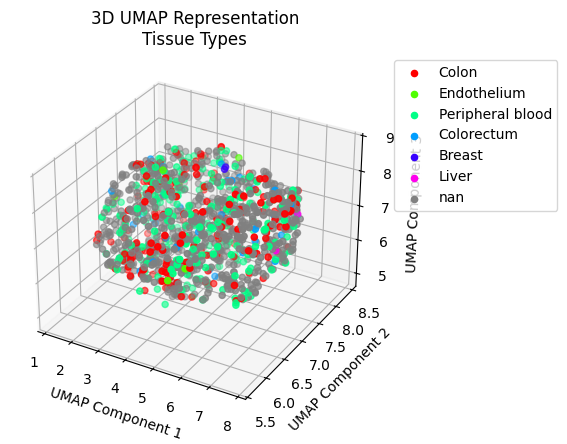

In [60]:
labels = adata_test.obs["tissue"].to_list()

unique_labels = list(set(labels))

# Get a color map
cmap = plt.get_cmap("hsv")

# Generate a unique color for each unique label
colors = [cmap(i / len(unique_labels)) for i in range(len(unique_labels))]

# Create a mapping from unique labels to colors
label_color_map = {
    label: color for label, color in zip(unique_labels, colors) if str(label) != "nan"
}
label_color_map.update({"nan": (0.5, 0.5, 0.5, 1.0)})

# Map the labels to their corresponding colors
assigned_colors = list()
for label in labels:
    assigned_colors.append(label_color_map[label])

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Scatter plot with colors
ax.scatter(
    umap_embedding[:, 0], umap_embedding[:, 1], umap_embedding[:, 2], c=assigned_colors
)

# Adding legend
for label in label_color_map:
    ax.scatter([], [], [], c=label_color_map[label], label=label)
ax.legend(loc="upper right", bbox_to_anchor=(1.5, 1))

# Set labels
ax.set_xlabel("UMAP Component 1")
ax.set_ylabel("UMAP Component 2")
ax.set_zlabel("UMAP Component 3")
ax.set_title("3D UMAP Representation\nTissue Types")

# Display the plot
# plt.savefig("outputs/umap_3d.scgpt.tissue_types.png", dpi=300, bbox_inches="tight")

Text(0.5, 0.92, '3D UMAP Representation\nDataset')

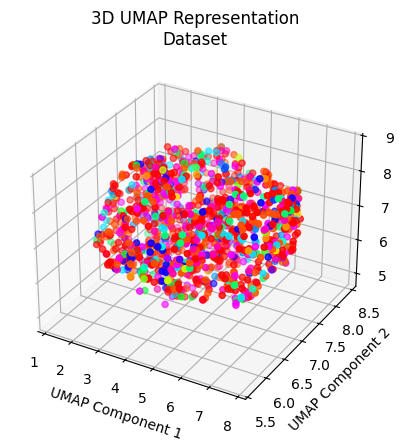

In [61]:
labels = adata_test.obs["dataset"].to_list()

unique_labels = list(set(labels))

# Get a color map
cmap = plt.get_cmap("hsv")

# Generate a unique color for each unique label
colors = [cmap(i / len(unique_labels)) for i in range(len(unique_labels))]

# Create a mapping from unique labels to colors
label_color_map = {
    label: color for label, color in zip(unique_labels, colors) if str(label) != "nan"
}
label_color_map.update({"nan": (0.5, 0.5, 0.5, 1.0)})

# Map the labels to their corresponding colors
assigned_colors = list()
for label in labels:
    assigned_colors.append(label_color_map[label])

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Scatter plot with colors
ax.scatter(
    umap_embedding[:, 0], umap_embedding[:, 1], umap_embedding[:, 2], c=assigned_colors
)

# Adding legend
# for label in label_color_map:
#     ax.scatter([], [], [], c=label_color_map[label], label=label)
# ax.legend(loc="upper right", bbox_to_anchor=(1.5, 1))

# Set labels
ax.set_xlabel("UMAP Component 1")
ax.set_ylabel("UMAP Component 2")
ax.set_zlabel("UMAP Component 3")
ax.set_title("3D UMAP Representation\nDataset")

# Display the plot
# plt.savefig("outputs/umap_3d.scgpt.dataset.png", dpi=300, bbox_inches="tight")

Text(0.5, 0.92, '3D UMAP Representation\nNº of Genes')

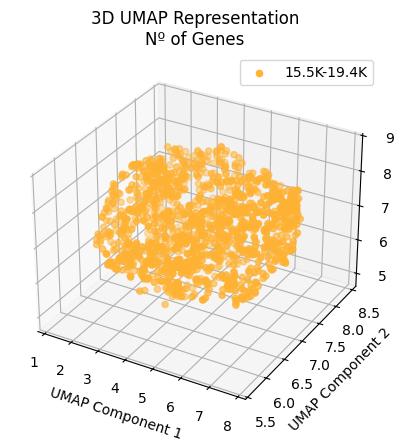

In [62]:
def format_number(n):
    """Format the number to include 'K' for thousands."""
    if n >= 1000:
        return f"{n/1000:.1f}K"
    return str(n)


def get_groups_by_counts(
    data,
    max_genes,
    n_groups=4,
):
    labels = list()
    bins = np.arange(0, max_genes + 1, max_genes / n_groups)
    formatted_bins = [format_number(bin) for bin in bins]

    for n_genes in data:
        for i, bin in enumerate(bins):
            if i == 0:
                label = f"<={formatted_bins[i]}"
            else:
                label = f"{formatted_bins[i-1]}-{formatted_bins[i]}"
            if n_genes <= bin:
                labels.append(label)
                break

    return labels


n_genes = adata_test.obs["n_genes"].to_list()
labels = get_groups_by_counts(n_groups=5, max_genes=max(n_genes), data=n_genes)
unique_labels = set(labels)

label_color_map = {
    k: v
    for k, v in zip(
        unique_labels, [irb_colors[0], irb_colors[4], irb_colors[2], irb_colors[1]]
    )
}
colors = [label_color_map.get(label, "grey") for label in labels]

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Scatter plot with colors
ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], umap_embedding[:, 2], c=colors)

# Adding legend
for label in label_color_map:
    ax.scatter([], [], [], c=label_color_map[label], label=label)
ax.legend()

# Set labels
ax.set_xlabel("UMAP Component 1")
ax.set_ylabel("UMAP Component 2")
ax.set_zlabel("UMAP Component 3")
ax.set_title("3D UMAP Representation\nNº of Genes")

# Display the plot
# plt.savefig("outputs/umap_3d.scgpt.n_genes.png", dpi=300, bbox_inches="tight")

## Plot Distances/Similarities

In [63]:
# compute cosine similarity matrix, pdist and cdist
from scipy.spatial.distance import cosine
from scipy.spatial.distance import pdist, cdist

# cosine similarity matrix
c_matrix = cdist(scgpt_emb_test, scgpt_emb_test, "cosine")

# euclidean distance matrix
e_matrix = cdist(scgpt_emb_test, scgpt_emb_test, "euclidean")

# pearson correlation matrix
p_matrix = 1 - cdist(scgpt_emb_test, scgpt_emb_test, "correlation")

Influenza


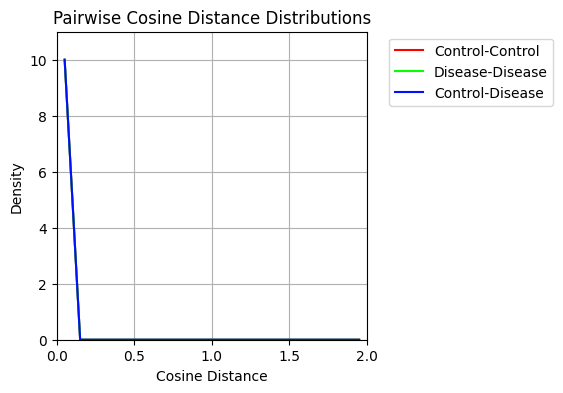

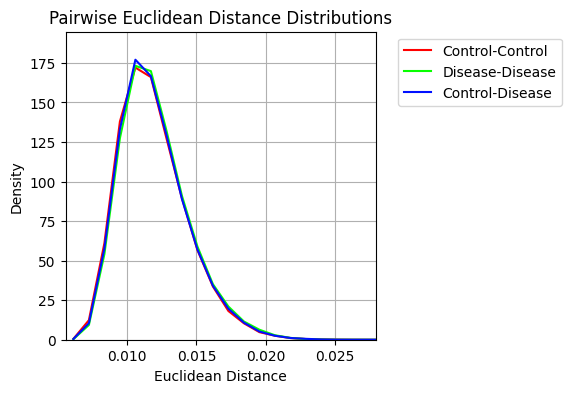

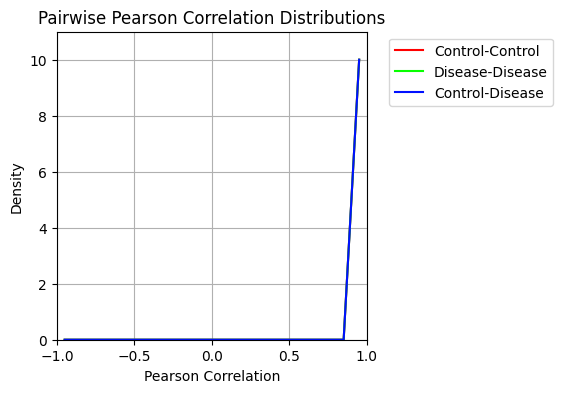

In [64]:
# get from cosine similarity matrix the cosine similarity between ctr and dis samples
states = adata_test.obs["disease"].to_list()
diseases = adata_test.obs["disease_study"].to_list()


c_ctr_ctr = np.array([])
c_ctr_dis = np.array([])
c_dis_dis = np.array([])

e_ctr_ctr = np.array([])
e_ctr_dis = np.array([])
e_dis_dis = np.array([])

p_ctr_ctr = np.array([])
p_ctr_dis = np.array([])
p_dis_dis = np.array([])

for disease_i in adata_test.obs["disease_study"].unique():
    ctr_indexes = list()
    dis_indexes = list()
    for i, (disease_j, state) in enumerate(zip(diseases, states)):
        if disease_i == disease_j and state == "Control":
            ctr_indexes.append(i)
        elif disease_i == disease_j and state != "Control":
            dis_indexes.append(i)

    # cosine
    c_ctr_ctr = np.concatenate(
        (c_ctr_ctr, get_pairwise_similarities(c_matrix, ctr_indexes))
    )

    c_ctr_dis = np.concatenate(
        (c_ctr_dis, get_pairwise_similarities(c_matrix, ctr_indexes, dis_indexes))
    )

    c_dis_dis = np.concatenate(
        (c_dis_dis, get_pairwise_similarities(c_matrix, dis_indexes))
    )

    # euclidean
    e_ctr_ctr = np.concatenate(
        (e_ctr_ctr, get_pairwise_similarities(e_matrix, ctr_indexes))
    )

    e_ctr_dis = np.concatenate(
        (e_ctr_dis, get_pairwise_similarities(e_matrix, ctr_indexes, dis_indexes))
    )

    e_dis_dis = np.concatenate(
        (e_dis_dis, get_pairwise_similarities(e_matrix, dis_indexes))
    )

    # pearson
    p_ctr_ctr = np.concatenate(
        (p_ctr_ctr, get_pairwise_similarities(p_matrix, ctr_indexes))
    )

    p_ctr_dis = np.concatenate(
        (p_ctr_dis, get_pairwise_similarities(p_matrix, ctr_indexes, dis_indexes))
    )

    p_dis_dis = np.concatenate(
        (p_dis_dis, get_pairwise_similarities(p_matrix, dis_indexes))
    )

print(disease_i)
# cosine
plot_metrics(
    [c_ctr_ctr, c_dis_dis, c_ctr_dis],
    ["Control-Control", "Disease-Disease", "Control-Disease"],
    "Cosine Distance",
    output_type="disease_control",
)

# euclidean
plot_metrics(
    [e_ctr_ctr, e_dis_dis, e_ctr_dis],
    ["Control-Control", "Disease-Disease", "Control-Disease"],
    "Euclidean Distance",
    output_type="disease_control",
)

# pearson
plot_metrics(
    [p_ctr_ctr, p_dis_dis, p_ctr_dis],
    ["Control-Control", "Disease-Disease", "Control-Disease"],
    "Pearson Correlation",
    output_type="disease_control",
)

In [66]:
adata_test.obs

,ids,dataset,batch,batch_id,dsaid,tissue,n_genes,disease,celltype,disease_study,celltype_id,test_split_1,test_split_2,test_split_3,test_split_4,test_split_5
59,DSA00131;GSM6939946;Control,GSE223120,57,57,DSA00131,Colorectum,19399,Control,Control,Colorectal Carcinoma,2,1,0,0,0,0
60,DSA00131;GSM6939947;Control,GSE223120,57,57,DSA00131,Colorectum,19399,Control,Control,Colorectal Carcinoma,2,1,0,0,0,0
61,DSA00131;GSM6939948;Control,GSE223120,57,57,DSA00131,Colorectum,19399,Control,Control,Colorectal Carcinoma,2,1,0,0,0,0
62,DSA00131;GSM6939949;Control,GSE223120,57,57,DSA00131,Colorectum,19399,Control,Control,Colorectal Carcinoma,2,1,0,0,0,0
63,DSA00131;GSM6939950;Control,GSE223120,57,57,DSA00131,Colorectum,19399,Control,Control,Colorectal Carcinoma,2,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5981,DSA10206;GSM459863;Control,GSE18462,80,80,DSA10206,Colon,17043,Control,Control,Colorectal Carcinoma,2,1,0,0,0,0
5982,DSA10207;GSM459859;Control,GSE18462,80,80,DSA10207,Liver,17043,Control,Control,Colorectal Carcinoma,2,1,0,0,0,0
5983,DSA10207;GSM459863;Control,GSE18462,80,80,DSA10207,Liver,17043,Control,Control,Colorectal Carcinoma,2,1,0,0,0,0
5984,DSA10207;GSM459861;Case,GSE18462,80,80,DSA10207,Liver,17043,Colorectal Carcinoma,Colorectal Carcinoma,Colorectal Carcinoma,1,1,0,0,0,0


In [67]:
def format_string(s):
    if len(s) > 8:
        return s[:7] + "."
    return s


diseases = adata_test.obs["disease"].to_list()
states = adata_test.obs["state"].to_list()

disease_labels = [x if y == "Case" else y for x, y in zip(diseases, states)]


idxs = list()
diseases = list(set(disease_labels))
n_diseases = len(diseases)

# get idxs for each disease
for disease in diseases:
    # idxs.append(
    #     [
    #         i
    #         for i, label in enumerate(disease_labels)
    #         if (label == disease) & (states[i] == "Case")
    #     ]
    # )

    idxs.append([i for i, label in enumerate(disease_labels) if label == disease])

labels = list()
values = list()
for i in range(n_diseases):

    for j in range(i, n_diseases):
        labels.append(f"{format_string(diseases[i])}-{format_string(diseases[j])}")
        if i == j:
            values.append(get_pairwise_similarities(c_matrix, idxs[i]))
        else:
            values.append(get_pairwise_similarities(c_matrix, idxs[i], idxs[j]))

plot_metrics(values, labels, "Cosine Distance", output_type="diseases")


labels = list()
values = list()
for i in range(n_diseases):

    for j in range(i, n_diseases):
        labels.append(f"{format_string(diseases[i])}-{format_string(diseases[j])}")
        if i == j:
            values.append(get_pairwise_similarities(e_matrix, idxs[i]))
        else:
            values.append(get_pairwise_similarities(e_matrix, idxs[i], idxs[j]))

plot_metrics(values, labels, "Euclidean Distance", output_type="diseases")


labels = list()
values = list()
for i in range(n_diseases):

    for j in range(i, n_diseases):
        labels.append(f"{format_string(diseases[i])}-{format_string(diseases[j])}")
        if i == j:
            values.append(get_pairwise_similarities(p_matrix, idxs[i]))
        else:
            values.append(get_pairwise_similarities(p_matrix, idxs[i], idxs[j]))

plot_metrics(values, labels, "Pearson Correlation", output_type="diseases")

KeyError: 'state'

['9.8K-14.8K', '9.8K-14.8K', '9.8K-14.8K', '9.8K-14.8K', '9.8K-14.8K', '9.8K-14.8K', '9.8K-14.8K', '9.8K-14.8K', '9.8K-14.8K', '9.8K-14.8K']


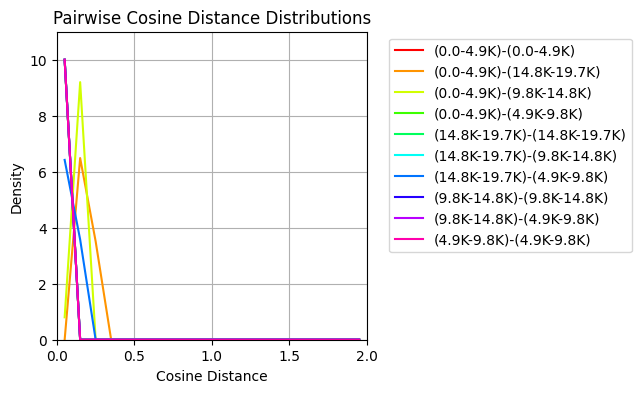

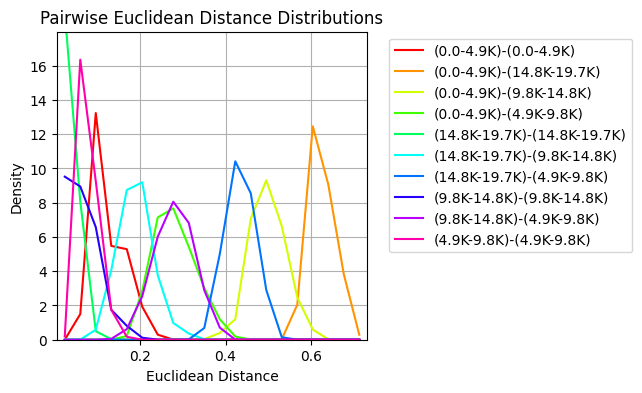

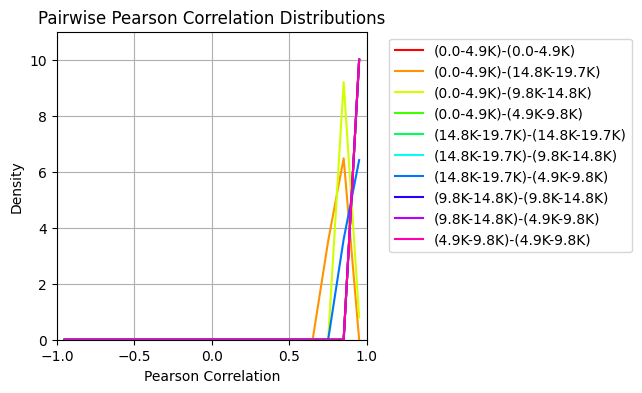

In [ ]:
def format_number(n):
    """Format the number to include 'K' for thousands."""
    if n >= 1000:
        return f"{n/1000:.1f}K"
    return str(n)


def get_groups_by_counts(data, n_groups=4):
    labels = list()
    bins = np.arange(0, 19690 + 1, 19690 / n_groups)
    formatted_bins = [format_number(bin) for bin in bins]

    for n_genes in data:
        for i, bin in enumerate(bins):
            if i == 0:
                label = f"<={formatted_bins[i]}"
            else:
                label = f"{formatted_bins[i-1]}-{formatted_bins[i]}"
            if n_genes <= bin:
                labels.append(label)
                break

    return labels


n_genes = raw_data.obs["n_genes"].to_list()
n_genes_labels = get_groups_by_counts(n_groups=4, data=n_genes)


print(n_genes_labels[:10])

idxs = list()
unique_labels = list(set(n_genes_labels))
n_labels = len(unique_labels)

# get idxs for each disease
for label in unique_labels:
    idxs.append([i for i, l in enumerate(n_genes_labels) if l == label])

labels = list()
values = list()
for i in range(n_labels):
    for j in range(i, n_labels):
        labels.append(f"({unique_labels[i]})-({unique_labels[j]})")
        if i == j:
            values.append(get_pairwise_similarities(c_matrix, idxs[i]))
        else:
            values.append(get_pairwise_similarities(c_matrix, idxs[i], idxs[j]))

plot_metrics(values, labels, "Cosine Distance", output_type="n_genes_labels")


labels = list()
values = list()
for i in range(n_labels):

    for j in range(i, n_labels):
        labels.append(f"({unique_labels[i]})-({unique_labels[j]})")
        if i == j:
            values.append(get_pairwise_similarities(e_matrix, idxs[i]))
        else:
            values.append(get_pairwise_similarities(e_matrix, idxs[i], idxs[j]))

plot_metrics(values, labels, "Euclidean Distance", output_type="n_genes_labels")


labels = list()
values = list()
for i in range(n_labels):

    for j in range(i, n_labels):
        labels.append(f"({unique_labels[i]})-({unique_labels[j]})")
        if i == j:
            values.append(get_pairwise_similarities(p_matrix, idxs[i]))
        else:
            values.append(get_pairwise_similarities(p_matrix, idxs[i], idxs[j]))

plot_metrics(values, labels, "Pearson Correlation", output_type="n_genes_labels")

In [ ]:
n_groups = 4
bins = np.arange(0, 19690 + 1, 19690 / n_groups)
formatted_bins = [format_number(bin) for bin in bins]

In [ ]:
formatted_bins

['0.0', '4.9K', '9.8K', '14.8K', '19.7K']

## MLP Prediction


In [44]:
"""MLP Prediction

Structure:  
    1. Imports, Variables, Functions
    2. Define Splits
    3. Train MLP
    4. Evaluate MLP

"""

# 1. Imports, Variables, Functions
# imports
import random
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# variables


# functions

# 2. Process Data
logging.info(f"Unfiltered shape: {raw_data.X.shape}")

# clean unknown values
mask_unknown = [
    False if x.split(";")[2] == "Unknown" else True for x in raw_data.obs["ids"].values
]

adata_clean = raw_data[mask_unknown]

embeddings = raw_data[mask_unknown]

embeddings.X[np.isnan(embeddings.X)] = 0

# embeddings = scgpt_embed[mask_unknown]


assert adata_clean.X.shape[0] == embeddings.X.shape[0]

logging.info(f"Filter Unknown values shape: {adata_clean.X.shape}")

# generate celltype and celltype_id columns in adata_clean.obs
disease_types = raw_data.obs["disease"].to_list()
states = raw_data.obs["state"].to_list()
disease_types_controls = [
    x if y == "Case" else y for x, y in zip(disease_types, states)
]
disease_type_2_id = {k: v for v, k in enumerate(set(disease_types_controls))}

disease_ids = [disease_type_2_id[x] for x in disease_types_controls]
del disease_type_2_id

adata_clean.obs["celltype"] = disease_types_controls

adata_clean.obs["celltype_id"] = disease_ids

logging.info(f"Counts of each disease type: {Counter(disease_types)}")


# generate dataset ids column in adata_clean.obs
dataset_ids = raw_data.obs["dataset"].to_list()
dataset_2_batch_id = {k: v for v, k in enumerate(set(dataset_ids))}
batch_ids = [dataset_2_batch_id[x] for x in dataset_ids]
del dataset_2_batch_id

adata_clean.obs["dataset_id"] = dataset_ids
adata_clean.obs["batch_id"] = batch_ids

logging.info(f"Counts of each dataset id: {Counter(dataset_ids)}")


# 3. Define Splits
# We combine both the disease type with the dataset as to
# shuffle even more the data - minimize bias in train/test split
labels = np.array([a + b for a, b in zip(disease_types, dataset_ids)])

# Generate indices for the data points
indices = np.arange(len(labels))

"""train_test_split cannot handle single label indexes

Because of this we will manually deal with these cases!

"""
indices_single_label = [i for i, x in enumerate(labels) if list(labels).count(x) == 1]
labels_single_label = labels[indices_single_label]

logging.info(f"Nº of single label indexes: {len(indices_single_label)}")


remaining_indices = [i for i in indices if i not in indices_single_label]
remaining_labels = labels[remaining_indices]

# Perform stratified split on the remaining indices
train_indices, test_indices = train_test_split(
    remaining_indices, test_size=0.3, stratify=remaining_labels, random_state=42
)

for idx in indices_single_label:

    if random.random() < 0.2:
        test_indices.append(idx)
    else:
        train_indices.append(idx)


test_indices.sort()
train_indices.sort()

batch_ids = np.zeros(len(labels))
batch_ids[test_indices] = 1


logging.info(f"Nº of train samples: {np.sum(~batch_ids.astype(bool))}")
logging.info(f"Nº of test samples: {np.sum(batch_ids.astype(bool))}")


adata_clean.obs["train_test"] = batch_ids
adata_clean.obs["str_batch"] = batch_ids.astype(int).astype(str)

INFO:root:Unfiltered shape: (5090, 19690)
/tmp/ipykernel_4672/414171329.py:37: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  embeddings.X[np.isnan(embeddings.X)] = 0
INFO:root:Filter Unknown values shape: (5090, 19690)
/tmp/ipykernel_4672/414171329.py:57: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_clean.obs["celltype"] = disease_types_controls
INFO:root:Counts of each disease type: Counter({'Breast Cancer': 2355, 'Colorectal Carcinoma': 1814, 'Influenza': 921})
INFO:root:Counts of each dataset id: Counter({'GSE54002': 431, 'GSE87211': 361, 'GSE41258': 321, 'GSE55276': 234, 'GSE55277': 234, 'GSE5364': 194, 'GSE45827': 162, 'GSE101702': 157, 'GSE27562': 146, 'GSE24124': 135, 'GSE47756': 127, 'GSE16443': 119, 'GSE42568': 119, 'GSE164191': 119, 'GSE29044': 107, 'GSE37751': 106, 'GSE33113': 94, 'GSE123086': 92, 'GSE9348': 80, 'GSE62932': 79, 'GSE29366': 67, 'GSE29431': 64

In [45]:
import sklearn

# define train test adata
adata_train = adata_clean[adata_clean.obs["str_batch"] == "0"]
adata_test = adata_clean[adata_clean.obs["str_batch"] == "1"]

embeddings_train = embeddings[adata_clean.obs["str_batch"] == "0"]
embeddings_test = embeddings[adata_clean.obs["str_batch"] == "1"]

assert adata_train.X.shape[0] == embeddings_train.X.shape[0]
assert adata_test.X.shape[0] == embeddings_test.X.shape[0]

logging.info(f"train shape: {embeddings_train.shape}")
logging.info(f"test shape: {embeddings_test.shape}")

# 3. Train MLP
X_train = embeddings_train.X
# X_train = np.where(np.isnan(adata_train.X), 0, adata_train.X)

y_train = adata_train.obs["celltype"].values


# Create and train the model
mlp = MLPClassifier(
    hidden_layer_sizes=(384, 256, 128, 64),  # Four hidden layers with varying sizes
    activation="relu",  # Activation function for the hidden layers
    solver="adam",  # Optimizer
    max_iter=500,  # Maximum number of iterations
    random_state=42,  # For reproducibility
)
mlp.fit(X_train, y_train)


# 4. Evaluate MLP
X_test = embeddings_test.X
# X_test = np.where(np.isnan(adata_test.X), 0, adata_test.X)
y_test = adata_test.obs["celltype"].values

# Predict
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

sklearn.metrics.f1_score(y_test, y_pred, average="weighted")


print("Predicted labels:", y_pred)
print("Accuracy:", accuracy)

INFO:root:train shape: (3563, 19690)
INFO:root:test shape: (1527, 19690)


Predicted labels: ['Control' 'Control' 'Control' ... 'Colorectal Carcinoma'
 'Colorectal Carcinoma' 'Colorectal Carcinoma']
Accuracy: 0.7210216110019646


In [46]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

report = classification_report(y_test, y_pred, output_dict=True)

print(report)

{'Breast Cancer': {'precision': 0.7337461300309598, 'recall': 0.9330708661417323, 'f1-score': 0.8214904679376083, 'support': 508.0}, 'Colorectal Carcinoma': {'precision': 0.8440366972477065, 'recall': 0.8046647230320699, 'f1-score': 0.8238805970149253, 'support': 343.0}, 'Control': {'precision': 0.7905405405405406, 'recall': 0.430939226519337, 'f1-score': 0.5578069129916567, 'support': 543.0}, 'Influenza': {'precision': 0.45348837209302323, 'recall': 0.8796992481203008, 'f1-score': 0.59846547314578, 'support': 133.0}, 'accuracy': 0.7210216110019646, 'macro avg': {'precision': 0.7054529349780575, 'recall': 0.76209351595336, 'f1-score': 0.7004108627724925, 'support': 1527.0}, 'weighted avg': {'precision': 0.7543058861909473, 'recall': 0.7210216110019646, 'f1-score': 0.7088364532883318, 'support': 1527.0}}


In [47]:
report_df = pd.DataFrame(report).transpose()
# Drop non-label rows (accuracy, macro avg, weighted avg)
report_df.drop(index=["accuracy", "macro avg", "weighted avg"], inplace=True)
report_df.drop(columns=["support"], inplace=True)

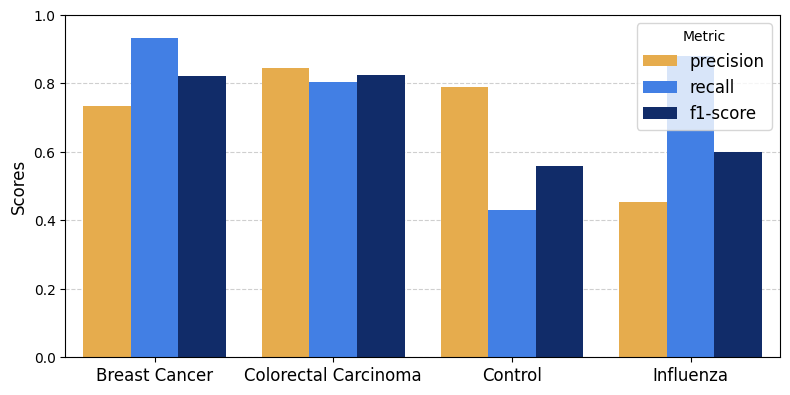

In [48]:
import seaborn as sns


# Creating the dataframe in a long format for seaborn
df_long = report_df.reset_index().melt(
    id_vars="index", var_name="Metric", value_name="Score"
)
df_long.columns = ["Condition", "Metric", "Score"]

custom_palette = {
    "precision": irb_colors[0],  # Blue
    "recall": irb_colors[3],  # Orange
    "f1-score": irb_colors[4],  # Green
}

# Plotting with seaborn
plt.figure(figsize=(8, 4))
sns.barplot(
    x="Condition",
    y="Score",
    hue="Metric",
    data=df_long,
    palette=custom_palette,
    zorder=2,
)

plt.grid(axis="y", linestyle="--", alpha=0.6, zorder=-3)

# Adding labels and title
plt.xlabel("")
plt.ylabel("Scores", fontsize=12)
plt.title("")

plt.legend(title="Metric", loc="upper right", fontsize=12)
plt.xticks(fontsize=12)

plt.tight_layout()
plt.ylim(0, 1)

plt.savefig(
    "outputs/classification_report_metrics_vertical.raw.png",
    dpi=300,
    bbox_inches="tight",
)


plt.show()

In [ ]:
sklearn.metrics.f1_score(y_test, y_pred, average="weighted")

0.4291957647416352

/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


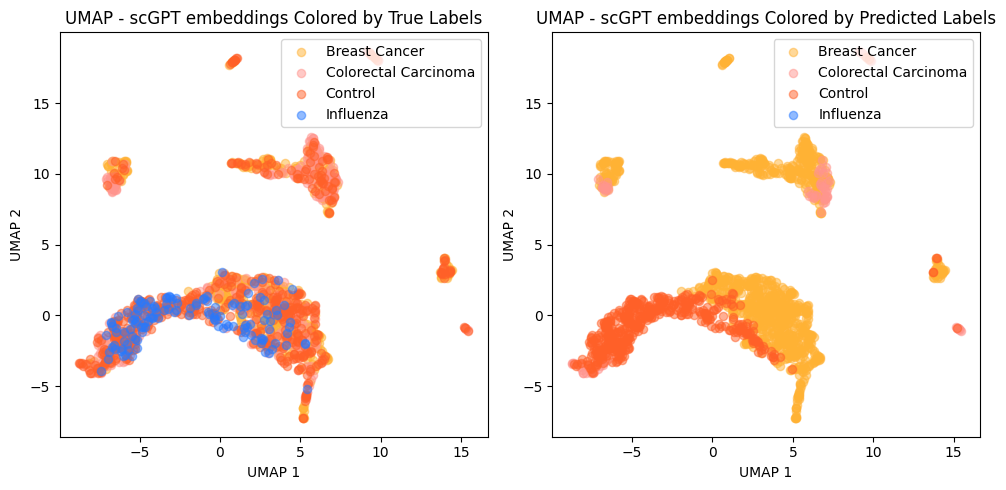

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your labels and corresponding colors
labels = np.unique(y_test)

# Create UMAP embeddings
reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=42)
X_test_umap = reducer.fit_transform(X_test)


color_map = {label: color for label, color in zip(labels, irb_colors)}

# Plotting the UMAP results
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# UMAP colored by true labels
for label in labels:
    idx = y_test == label
    axes[0].scatter(
        X_test_umap[idx, 0],
        X_test_umap[idx, 1],
        c=color_map[label],
        label=label,
        s=35,
        alpha=0.5,
    )
axes[0].set_title("UMAP - scGPT embeddings Colored by True Labels")
axes[0].legend()
axes[0].set_xlabel("UMAP 1")
axes[0].set_ylabel("UMAP 2")

# UMAP colored by predicted labels
for label in labels:
    idx = y_pred == label
    axes[1].scatter(
        X_test_umap[idx, 0],
        X_test_umap[idx, 1],
        c=color_map[label],
        label=label,
        s=35,
        alpha=0.5,
    )
axes[1].set_title("UMAP - scGPT embeddings Colored by Predicted Labels")
axes[1].legend()
axes[1].set_xlabel("UMAP 1")
axes[1].set_ylabel("UMAP 2")º

plt.tight_layout()
plt.savefig("outputs/umap_raw_data_pred_labels.scgpt.png", dpi=300, bbox_inches="tight")

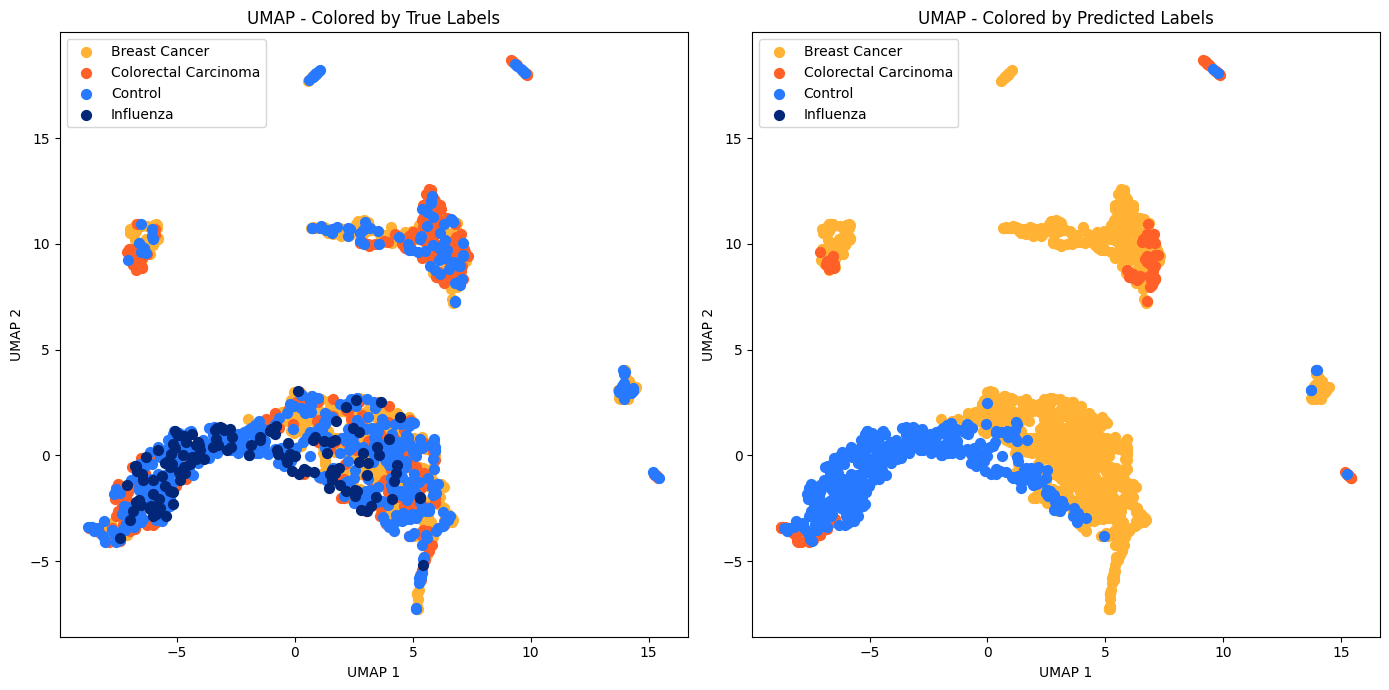

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your labels and corresponding colors
labels = np.unique(y_test)


color_map = {
    label: color for label, color in zip(labels, irb_colors[:1] + irb_colors[2:])
}

# Plotting the UMAP results
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# UMAP colored by true labels
for label in labels:
    idx = y_test == label
    axes[0].scatter(
        X_test_umap[idx, 0], X_test_umap[idx, 1], c=color_map[label], label=label, s=50
    )
axes[0].set_title("UMAP - Colored by True Labels")
axes[0].legend()
axes[0].set_xlabel("UMAP 1")
axes[0].set_ylabel("UMAP 2")

# UMAP colored by predicted labels
for label in labels:
    idx = y_pred == label
    axes[1].scatter(
        X_test_umap[idx, 0], X_test_umap[idx, 1], c=color_map[label], label=label, s=50
    )
axes[1].set_title("UMAP - Colored by Predicted Labels")
axes[1].legend()
axes[1].set_xlabel("UMAP 1")
axes[1].set_ylabel("UMAP 2")

plt.tight_layout()
plt.savefig(
    "outputs/umap.scgpt_embed.pred_labels.raw.png", dpi=300, bbox_inches="tight"
)

In [44]:
group_non_nan_counts

array([[2.],
       [3.]])